In [1]:
import cv2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


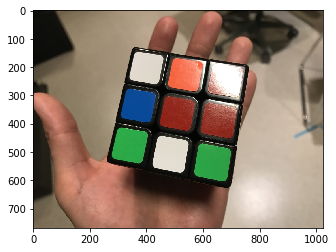

In [3]:
im = cv2.imread('cube-glare.jpg')
imshow(im[:, :, ::-1])

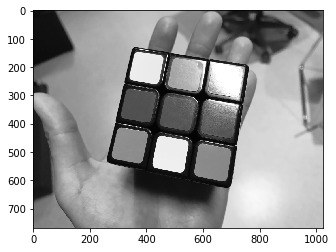

In [91]:
bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
imshow(bw, cmap='Greys_r')

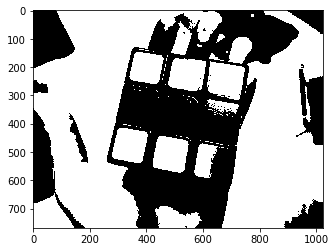

In [99]:
th = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 1001, 2)
imshow(th, cmap='Greys_r')

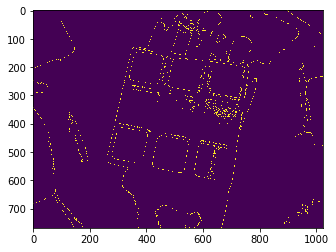

In [100]:
edges = cv2.Canny(th, 150, 200)
imshow(edges)

36


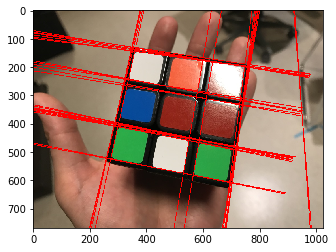

In [104]:
canvas = np.copy(im)
lines = cv2.HoughLines(edges, 1, 0.01, 100)
print(len(lines))
for rho, theta in lines[:, 0, :]:
    a, b = np.cos(theta), np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 2)

imshow(canvas[:, :, ::-1])

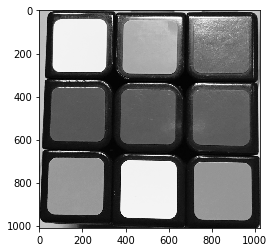

In [33]:
cube = cv2.imread('cube.jpg', cv2.IMREAD_GRAYSCALE)
imshow(cube, 'Greys_r')

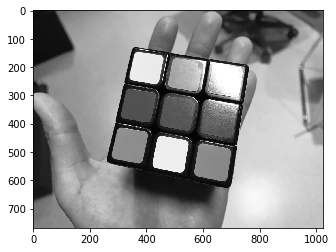

In [69]:
im = cv2.imread('cube-glare.jpg', cv2.IMREAD_GRAYSCALE)
imshow(im, 'Greys_r')

In [34]:
sift = cv2.xfeatures2d.SIFT_create()

In [35]:
kp1, des1 = sift.detectAndCompute(cube, None)
kp2, des2 = sift.detectAndCompute(im, None)

In [36]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 10)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [143]:
len(kp1), len(kp2)

(1527, 411)

In [136]:
len(matches)

1527

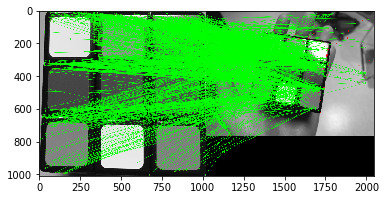

In [137]:
img1 = cube
img2 = im
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()
imsave('matches.png', img3)

In [101]:
MIN_MATCH_COUNT = 10
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

print('# of goods', len(good))
        
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h,w = cube.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(im,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print('Not enough matches are found - %d/%d' % (len(good), MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(
    matchColor = (0,255,0),
    singlePointColor = None,
    matchesMask = matchesMask,
    flags = 2)

# img3 = cv2.drawMatchesKnn(cube,kp1,img2,kp2,good,None,**draw_params)

# of goods 89


SystemError: <built-in function drawMatchesKnn> returned NULL without setting an error

In [138]:
mm, _ = zip(*matches)
src_pts = np.float32([ kp1[m.queryIdx].pt for m in mm]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in mm]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0, maxIters=1000, confidence=0.999)
matchesMask = mask.ravel().tolist()
print(sum(mask))

117


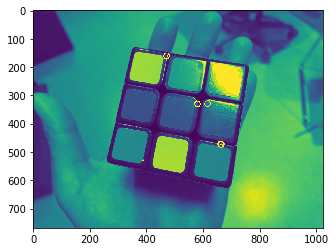

In [139]:
canvas = np.copy(im)
for masked, (x, y) in zip(matchesMask, dst_pts[:, 0, :]):
    if masked:
        canvas = cv2.circle(canvas, (x, y), 10, 255, 2)

h,w = cube.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

canvas = cv2.polylines(canvas,[np.int32(dst)], True, 255, 3, cv2.LINE_AA)
imshow(canvas)

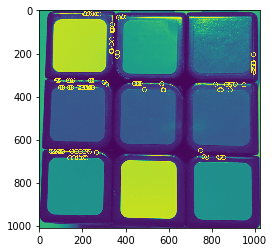

In [140]:
canvas = np.copy(cube)
for masked, (x, y) in zip(matchesMask, src_pts[:, 0, :]):
    if masked:
        canvas = cv2.circle(canvas, (x, y), 10, 255, 2)
imshow(canvas)

In [98]:
M

array([[ 3.85744995e+00,  3.30418667e-01,  2.95001060e+02],
       [ 1.75542419e+00,  1.73222783e+00, -6.29395174e+01],
       [ 7.37302192e-03,  9.53980297e-04,  1.00000000e+00]])

In [99]:
dst

array([[[388.58408, 530.03864]],

       [[388.38077, 528.5763 ]],

       [[387.94836, 528.752  ]],

       [[389.17773, 529.73846]]], dtype=float32)

In [144]:
surf = cv2.xfeatures2d.SURF_create()

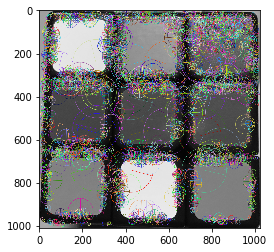

In [156]:
kps = surf.detect(cube)
canvas = cv2.drawKeypoints(cube, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(canvas)
imsave('surf-kps.png', canvas)

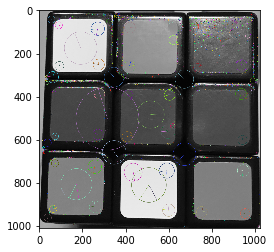

In [159]:
kps = sift.detect(cube)
canvas = cv2.drawKeypoints(cube, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(canvas)
imsave('sift-kps.png', canvas)

In [166]:
orb = cv2.ORB_create()

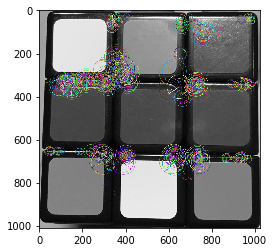

In [167]:
kps = orb.detect(cube)
canvas = cv2.drawKeypoints(cube, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(canvas)
imsave('orb-kps.png', canvas)

In [ ]:
kps = sift.detect(cube)
canvas = cv2.drawKeypoints(cube, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(canvas)
imsave('sift-kps.png', canvas)

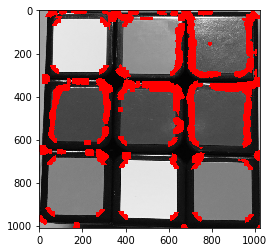

In [192]:
dst = cv2.cornerHarris(th, 32, 17, 0.01)
canvas = cv2.cvtColor(cube, cv2.COLOR_GRAY2BGR)
canvas[dst>0.02*dst.max()]=[255,0,0]
# canvas = cv2.drawKeypoints(cube, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(canvas)
# imsave('harris-kps.png', canvas)

In [ ]:
# SIFT produces the best large features, c.f. ORB, SURF. 
# We need to remove the small features

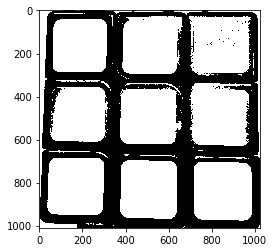

In [191]:
th = cv2.adaptiveThreshold(cube, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 513, 16)
imshow(th, 'Greys_r')
imsave('th-cube.png', th)

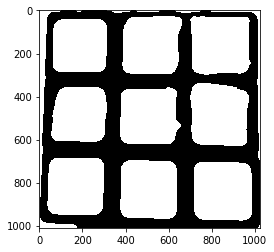

In [200]:
dst = cv2.medianBlur(th, 33)
imshow(dst, 'Greys_r')

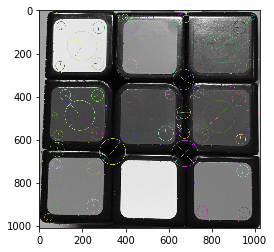

In [205]:
kps = sift.detect(dst)
canvas = cv2.drawKeypoints(cube, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(canvas)
imsave('sift-th-kps.png', canvas)

(array([254.,   8.,   8.,   5.,   5.,  10.,  10.,  17.,  12.,   2.,   0.,
          0.,   3.,   0.,   0.,   0.,   6.,   0.,   5.,   5.]),
 array([  2.12374926,   9.45759399,  16.79143872,  24.12528346,
         31.45912819,  38.79297292,  46.12681766,  53.46066239,
         60.79450712,  68.12835186,  75.46219659,  82.79604132,
         90.12988605,  97.46373079, 104.79757552, 112.13142025,
        119.46526499, 126.79910972, 134.13295445, 141.46679919,
        148.80064392]),
 <a list of 20 Patch objects>)

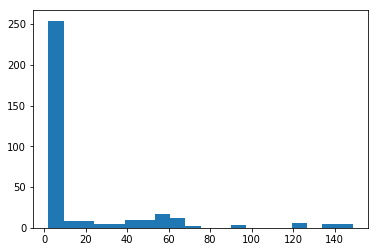

In [216]:
hist(list(map(lambda x: x.size, kps)), 20)

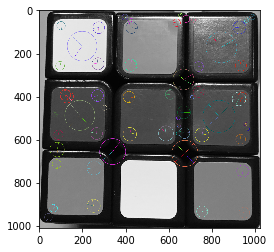

In [217]:
canvas = cv2.drawKeypoints(cube, [kp for kp in kps if kp.size > 10], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(canvas)
imsave('sift-th-kps-10.png', canvas)

In [223]:
kps = [kp for kp in kps if kp.size > 10]

In [224]:
len(kps)

95

In [225]:
_, des = sift.compute(dst, kps)

In [227]:
des.shape

(95, 128)

In [265]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 10)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des, des, k=5)

In [266]:
len(matches)

95

In [267]:
matches[0]

[<DMatch 0x13139c090>,
 <DMatch 0x13139cbd0>,
 <DMatch 0x13139cd30>,
 <DMatch 0x13139c750>,
 <DMatch 0x13139cf90>]

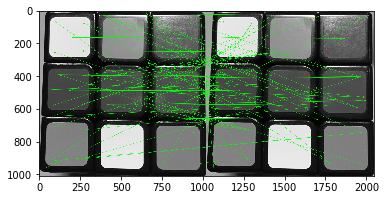

In [275]:
# XXX matchesMask has to be a list of lists
matchesMask = [[0, 1, 0, 0, 0]] * len(matches)
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
match_img = cv2.drawMatchesKnn(cube, kps, cube, kps, matches, None, **draw_params)
imshow(match_img)
imsave('self-matches.png', img3)

In [335]:
# Note the four-fold symmetry of a square (excluding flip which will double this)
# H : src -> dst : src_pts[i] |-> dst_pts[i]. We need to add all possible dst points.
src_pts = concatenate([[kp.pt] * 4 for kp in kps])
dst_pts = concatenate([[kps[ma.trainIdx].pt for ma in match[1:]] for match in matches])
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 0.1, None, 2000, 0.99)
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.LMEDS, 1, None, 2000, 0.99)

In [336]:
sum(mask)

20

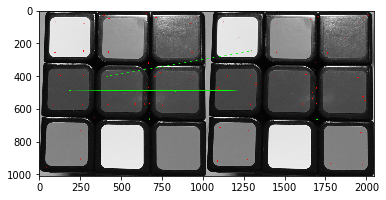

In [339]:
match_mask = hstack((zeros((95, 1), dtype='i'), mask.reshape((-1, 4)))).tolist()
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = match_mask,
                   flags = 0)

match_img = cv2.drawMatchesKnn(cube, kps, cube, kps, matches, None, **draw_params)
imshow(match_img)
imsave('self-matches-0.1.png', match_img)